# K-prototypes demo

* [Data Overview](#scrollTo=152d3fd8)
* [Data Preprocessing](#scrollTo=cd3ae76f)
* [EDA](#scrollTo=exXTN9ru0sHq&line=1&uniqifier=1)
* [Feature Transformation](#scrollTo=SFl5yRyL0yT6&line=1&uniqifier=1)
* [UMAP Visualization](#scrollTo=f4d031bb&line=1&uniqifier=1)
* [Mixed Distance Matrix](#scrollTo=c4d98dda&line=1&uniqifier=1)
* [Silhouette Plot per Cluster](#scrollTo=XfjF1s762_SH&line=1&uniqifier=1)
* [Cluster & Feature Analysis](#scrollTo=c0fb3b76&line=1&uniqifier=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
# data licence: https://github.com/IBM/telco-customer-churn-on-icp4d
#import sys
#!{sys.executable} -m pip install kmodes

import random
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples

# import umap
# import umap.plot as uplot

from numba import njit

random.seed(42)
sns.set_theme()

In [ ]:
# Remove all umap-related packages
!pip uninstall umap umap-learn -y

# Clear any cached modules
import sys
modules_to_remove = [key for key in sys.modules.keys() if 'umap' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Reinstall umap-learn
!pip install umap-learn

# Now try importing with the full path
import umap.umap_ as umap
# import umap.plot as umap_plot

Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install kneed

In [ ]:
!pip install kmodes

In [ ]:
!pip install gower

In [ ]:
from kneed import KneeLocator
from kmodes.kprototypes import KPrototypes
import gower

---

# Dataset description

The Telco Churn Dataset is a customer behavior dataset that includes information about a telecommunications company's customers and whether or not they discontinued their services within the last month (churned). The dataset is typically used to create predictive models to identify customers who are likely to churn in the future.

- **customerID**: This is a unique identifier for each customer in the dataset.

- **gender**: This indicates the gender of the customer, typically "Male" or "Female".
- **SeniorCitizen**: This is a binary indicator of whether the customer is a senior citizen or not.
- **Partner**: This is a binary indicator of whether the customer has a partner or not.
- **Dependents**: This is a binary indicator of whether the customer has any dependents or not.
- **tenure**: This represents the number of months the customer has been with the company.
- **PhoneService**: This is a binary indicator of whether the customer has a phone service or not.
- **MultipleLines**: This indicates whether the customer has multiple telephone lines.
- **InternetService**: This describes the type of internet service the customer has, typically DSL, Fiber optic, or None.
- **OnlineSecurity**: This is a binary indicator of whether the customer has online security services or not.
- **OnlineBackup**: This is a binary indicator of whether the customer has online backup services or not.
- **DeviceProtection**: This is a binary indicator of whether the customer has device protection services or not.
- **TechSupport**: This is a binary indicator of whether the customer has technical support services or not.
- **StreamingTV**: This is a binary indicator of whether the customer has streaming TV services or not.
- **StreamingMovies**: This is a binary indicator of whether the customer has streaming movie services or not.
- **Contract**: This describes the type of contract the customer has with the company, typically Month-to-month, One year, or Two year.
- **PaperlessBilling**: This is a binary indicator of whether the customer has opted for paperless billing or not.
- **PaymentMethod**: This describes the payment method that the customer uses, such as Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic).
- **MonthlyCharges**: This represents the amount charged to the customer monthly.
- **TotalCharges**: This represents the total amount charged to the customer.
- **Churn**: This is a binary indicator of whether the customer churned (discontinued their services) in the last month or not.

Citation : IBM Sample Data Sets - Telco customer churn

# Data loading and preprocessing

In [ ]:
# Load the data
telco_path = '/content/drive/MyDrive/Colab/Datasets/telco-customer-churn.csv'
# telco_path = '/data/telco-customer-churn.csv' # USE THIS ON LOCALLY

telco_df = pd.read_csv(telco_path)
telco_df = telco_df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Dataset shape
telco_df.shape

(7043, 21)

In [ ]:
# Check for missing values
telco_df.isnull().sum(axis=0)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
telco_df['SeniorCitizen'] = telco_df['SeniorCitizen'].astype(int).astype('object')

In [ ]:
# Remove rows with non existing TotalCharges
telco_df = telco_df[telco_df['TotalCharges']!=' ']
telco_df['TotalCharges'] = telco_df['TotalCharges'].astype(float)

In [ ]:
telco_df.shape

(7032, 21)

In [ ]:
# Get copy of dataframe in order to preserve original values for cluster analysis
original_df = telco_df.copy()

In [ ]:
# Remove columns that will not be used for clustering
other_cols = ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
other_df = telco_df.loc[:, other_cols]
telco_df = telco_df.dropna().drop(columns=other_cols)

# Baseline EDA

In [ ]:
# Describe numerical attributes of the data
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


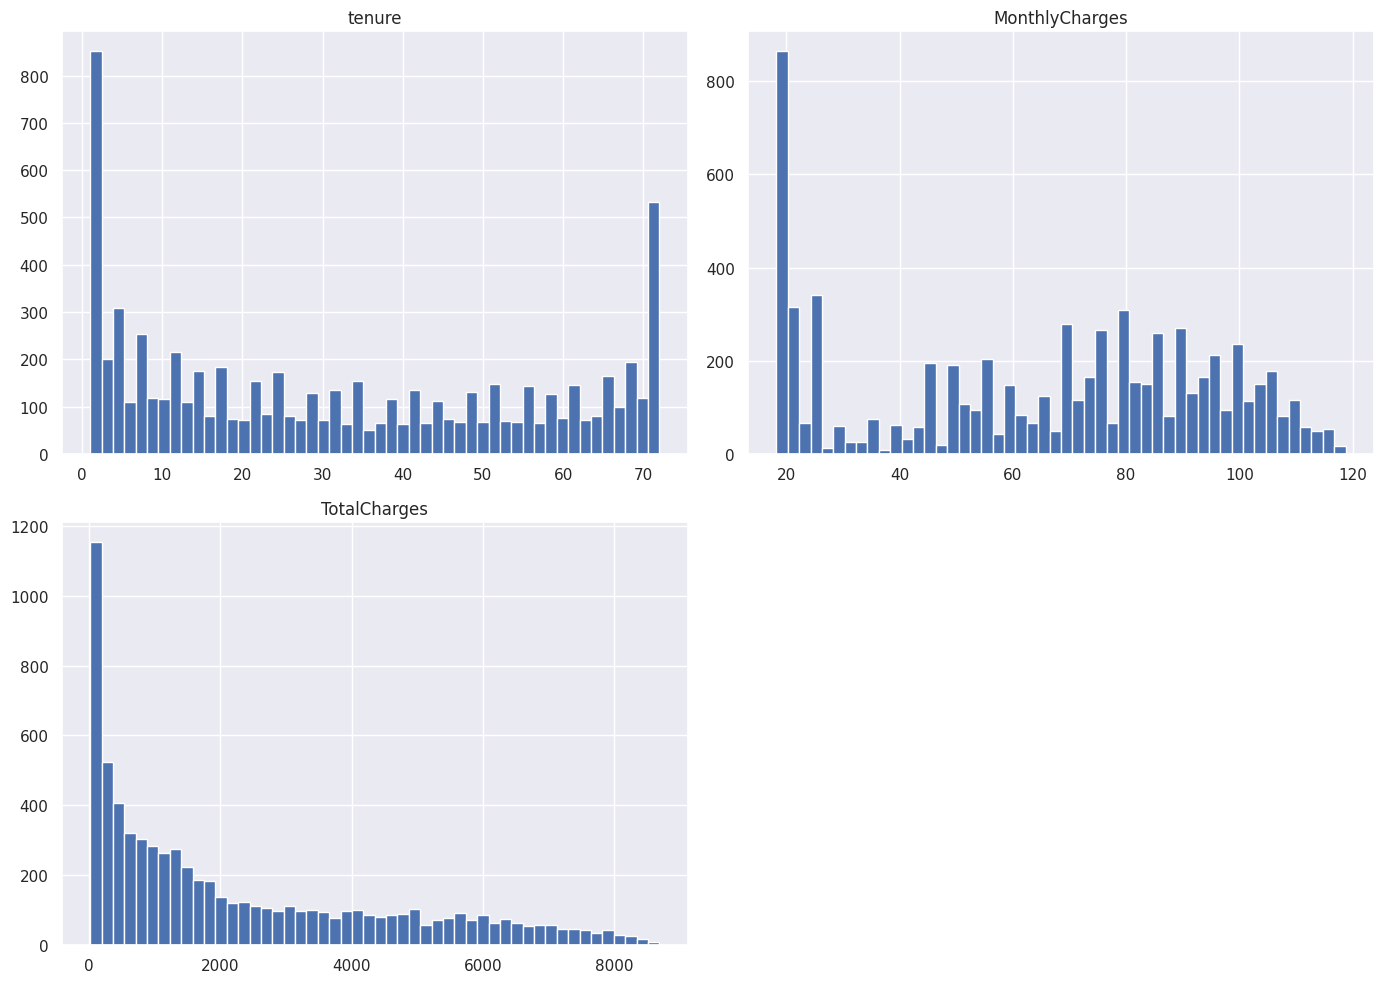

In [ ]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

In [ ]:
# check variable skew
print(telco_df['TotalCharges'].skew())
print(telco_df['MonthlyCharges'].skew())
print(telco_df['tenure'].skew())

0.9616424997242504
-0.22210292770166232
0.23773083190513133


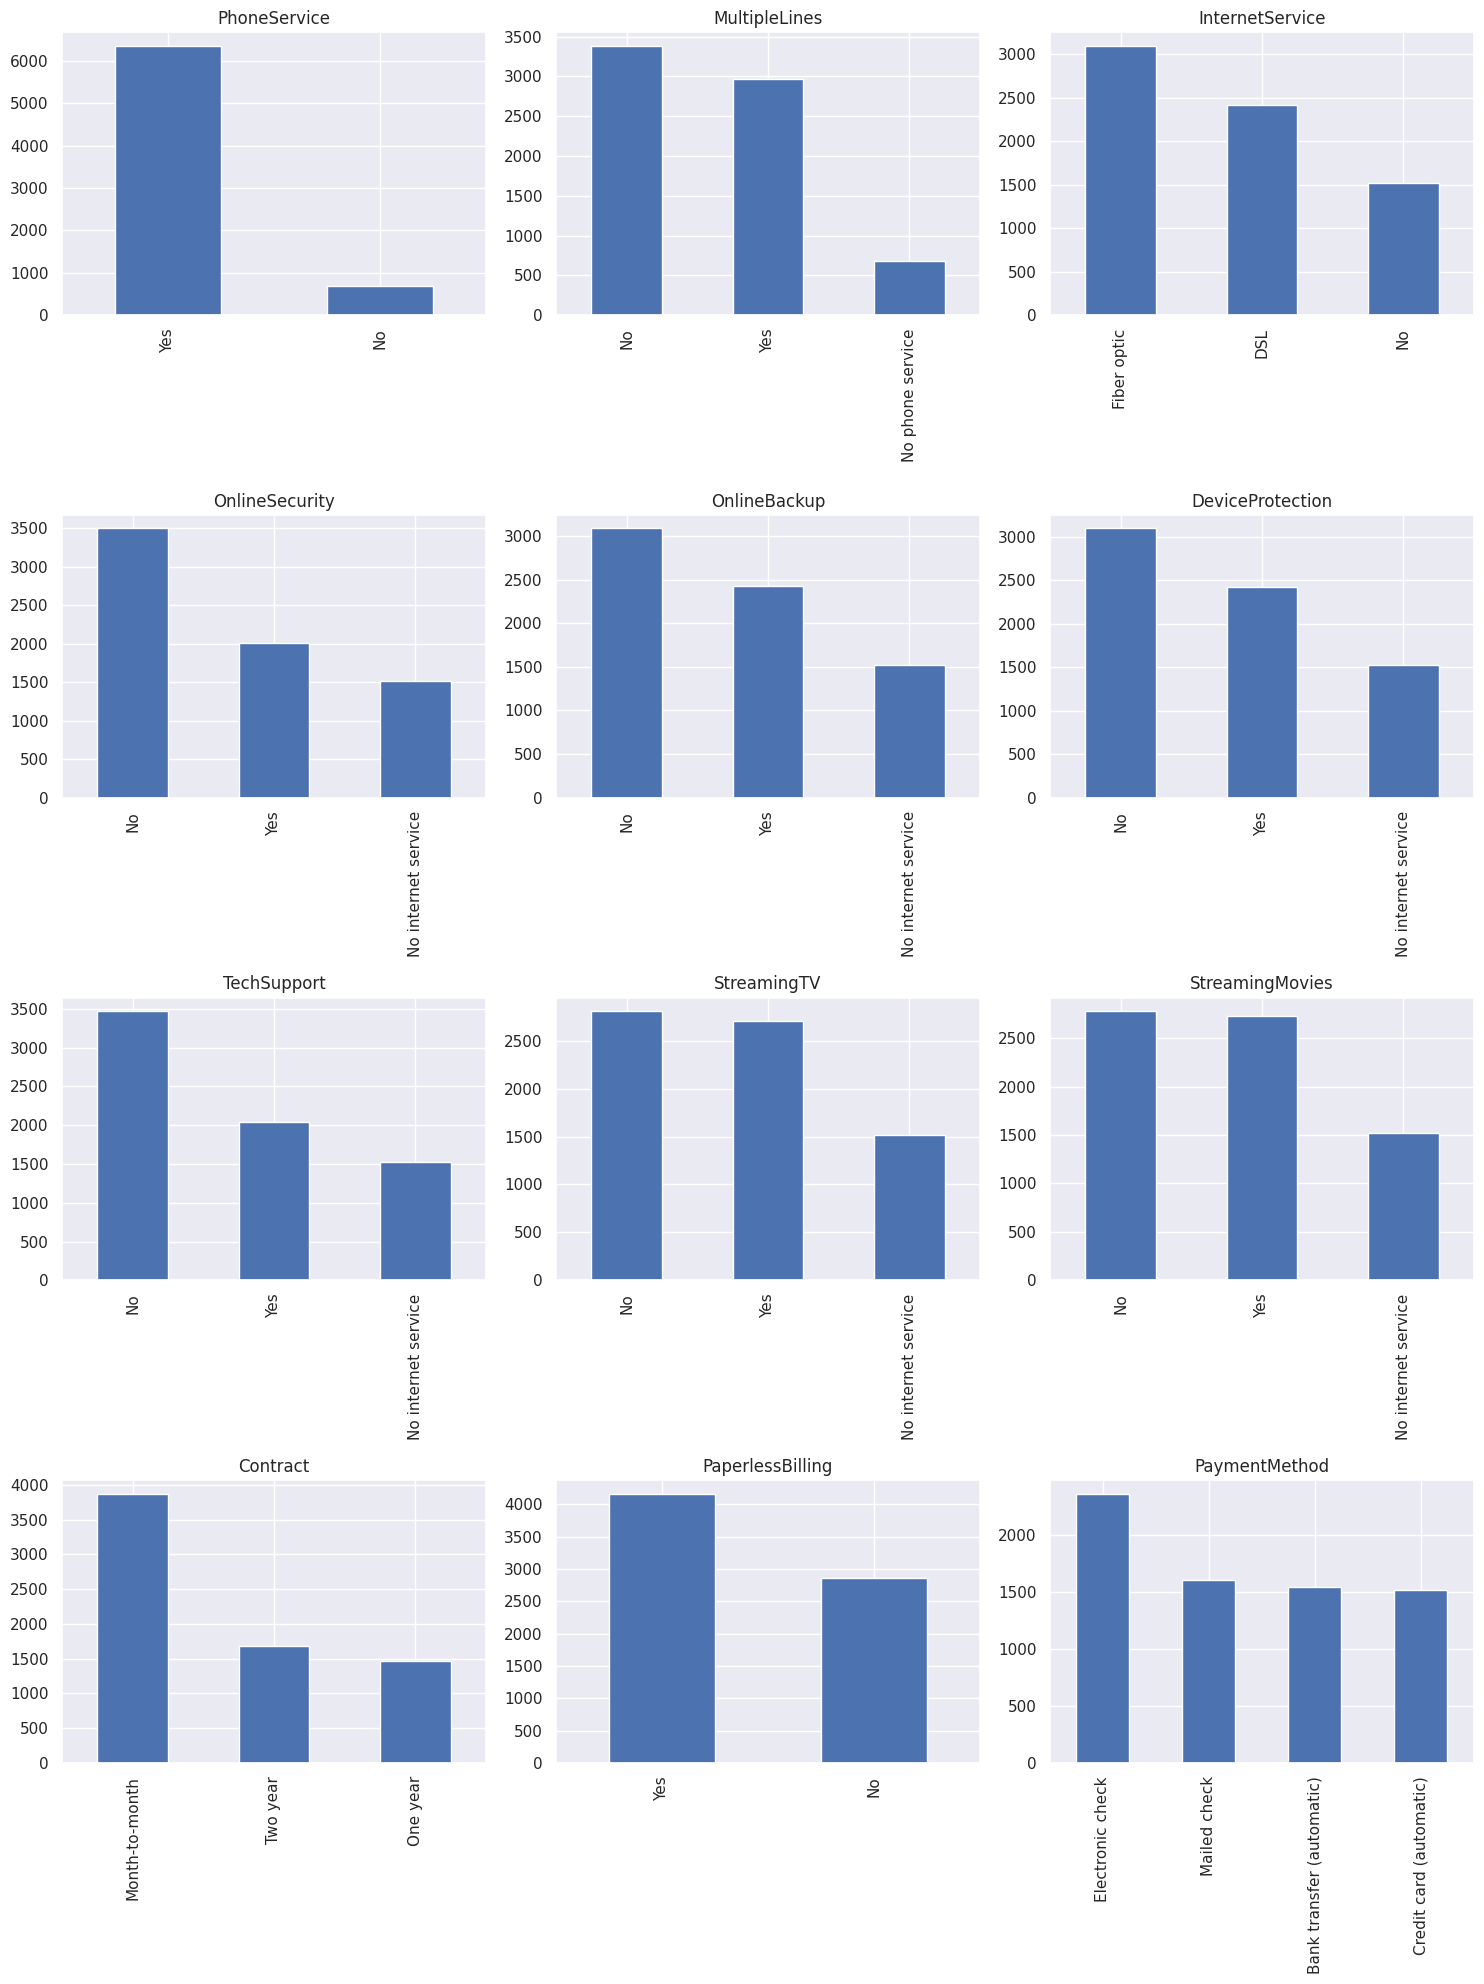

In [ ]:
# Plot categorical columns
categ_cols = telco_df.select_dtypes(include=['object']).columns
num_plots = len(categ_cols)

# Determine number of rows needed for the grid
num_rows = math.ceil(num_plots / 3.0)

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Flatten the axes array if there's more than one row
axs = axs.flatten()

# Plot data
for i, column in enumerate(categ_cols):
    ax = axs[i]
    telco_df[column].value_counts().plot(
        kind='bar',
        ax=ax,
        title=column,
        xlabel=''
    )

plt.tight_layout()

In [ ]:
# Get numerical and categorical columns
num_cols = list(set(telco_df.columns)-set(categ_cols))

# Scale numerical columns
telco_df['TotalCharges'] = np.sqrt(telco_df['TotalCharges'])
print(telco_df['TotalCharges'].skew())

0.3089261418986736


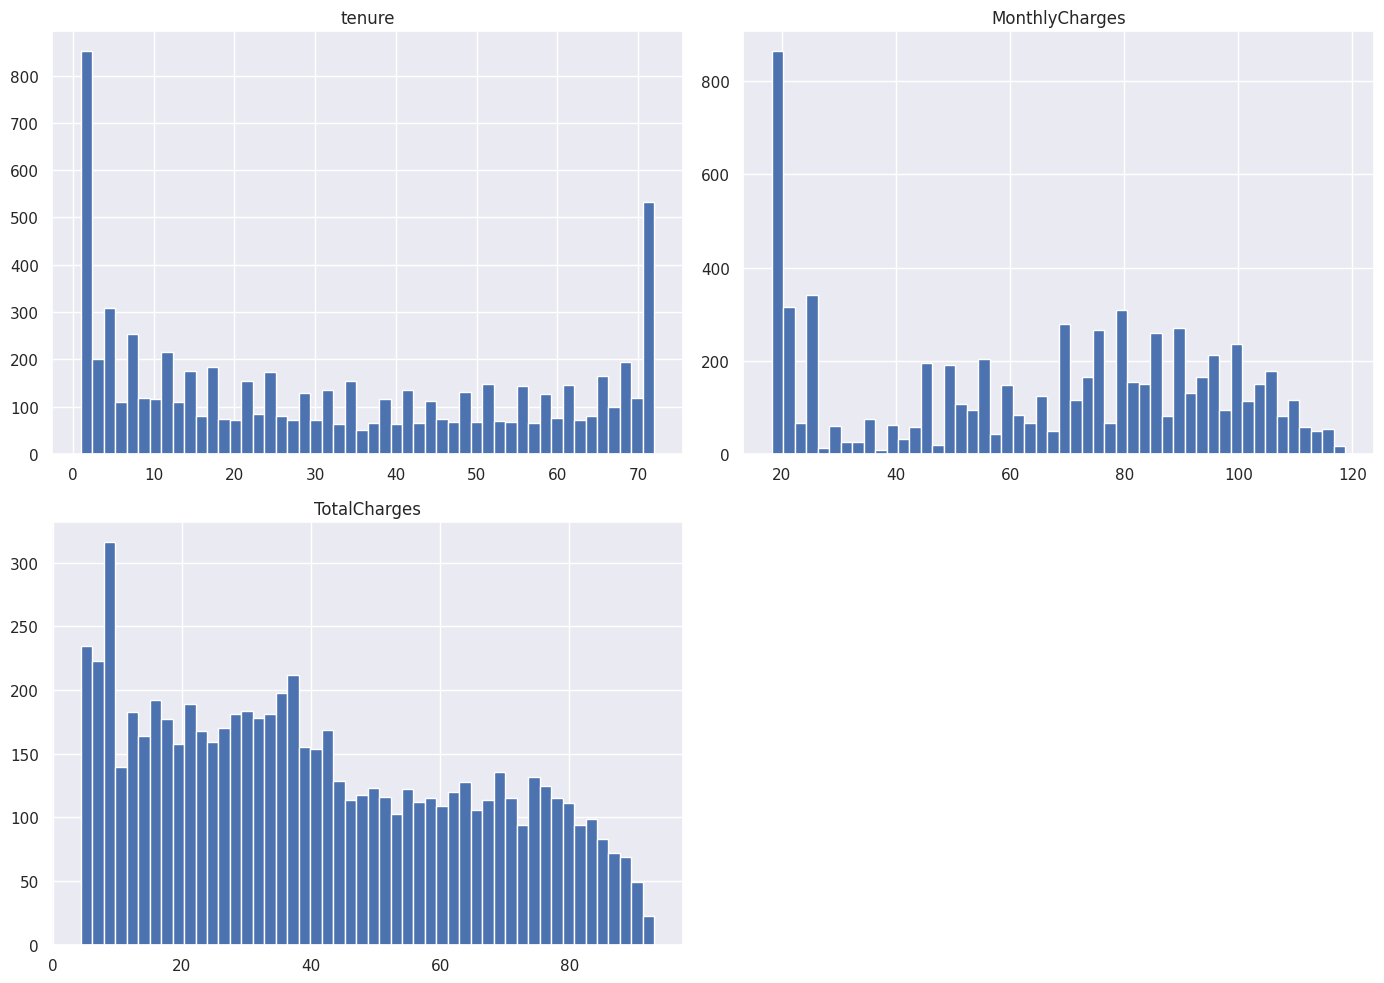

In [ ]:
# Plot numerical variables
_ = telco_df.hist(bins=50, figsize=(14,10))

# This line ensures the subplots do not overlap
plt.tight_layout()
plt.show()

# Feature Transformation

In [ ]:
# Scale numerical columns
standard_scaler = MinMaxScaler()
telco_df[num_cols] = standard_scaler.fit_transform(telco_df[num_cols])

# Encode categorical columns
ord_encoder = OrdinalEncoder(dtype=np.int32)
telco_df[categ_cols] = ord_encoder.fit_transform(telco_df[categ_cols])

In [ ]:
print(telco_df.shape)
telco_df.head()

(7032, 15)


,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0.000000,0,1,0,0,2,0,0,0,0,0,1,2,0.115423,0.012690
1,0.464789,1,0,0,2,0,2,0,0,0,1,0,3,0.385075,0.440402
2,0.014085,1,0,0,2,2,0,0,0,0,0,1,3,0.354229,0.068241
3,0.619718,0,1,0,2,0,2,2,0,0,1,0,0,0.239303,0.434049
4,0.014085,1,0,1,0,0,0,0,0,0,0,1,2,0.521891,0.089794


In [ ]:
# Get positions of categorical and numerical columns
df_cols = list(telco_df.columns)

numerical_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in num_cols]
)

categ_idx = np.array(
    [idx for idx, element in enumerate(df_cols) if element in categ_cols]
)

categ_bool = [True if element in categ_cols else False for element in df_cols]

print(numerical_idx)
print(categ_idx)
print(categ_bool)

[ 0 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[False, True, True, True, True, True, True, True, True, True, True, True, True, False, False]


# UMAP Embedding

In [ ]:
pairwise_gower = gower.gower_matrix(telco_df, cat_features=categ_bool)
print(pairwise_gower.shape)

(7032, 7032)


In [ ]:
# Embed with umap
# UMAP using precomputed distance metric maxtr(pairwise_gower)
umap_model = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42,
    metric='precomputed', # precomputed distance matrix
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

# uplot.points(umap_model)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# umap.plot.connectivity(umap_model, show_points=True)

In [ ]:
# umap.plot.diagnostic(umap_model, diagnostic_type='pca')

<Axes: >

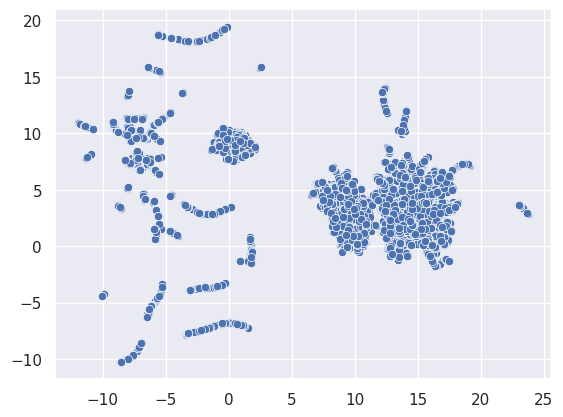

In [ ]:
sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
    )

In [ ]:
# Embed with umap
umap_model = umap.UMAP(
    n_neighbors=300,
    n_components=2,
    random_state=42,
    metric='precomputed',
    min_dist=0.3
)
umap_emb_data = umap_model.fit_transform(pairwise_gower)

# uplot.points(umap_model)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# umap.plot.connectivity(umap_model, show_points=True)

In [ ]:
# umap.plot.diagnostic(umap_model, diagnostic_type='pca')

<Axes: >

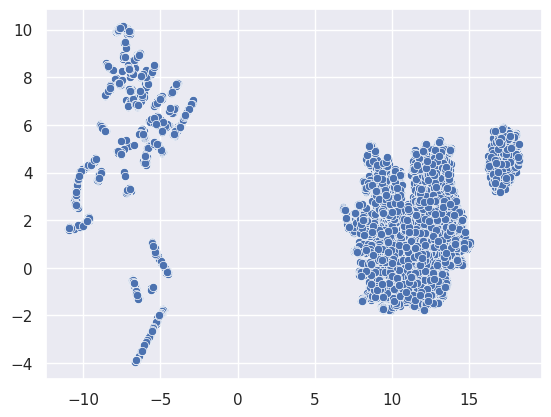

In [ ]:
sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
    );

# Mixed distance and k-prototypes

In [ ]:
gamma = 1/2 * telco_df[num_cols].std().mean()
gamma

np.float64(0.15354419462541744)

In [ ]:
def kproto_dist(x, y, num_idx, categ_idx, gamma):

    euclidean_part = np.sum(np.square(x[num_idx] - y[num_idx]))
    hamming_part = np.sum(x[categ_idx] == y[categ_idx])

    return euclidean_part + gamma*hamming_part

In [ ]:
@njit
def kproto_dist_nmb(x, y, num_idx, categ_idx, gamma):

    euclidean_part = 0
    for i in num_idx:
        euclidean_part += (x[i] - y[i]) ** 2

    hamming_part = 0
    for i in categ_idx:
        if x[i] != y[i]:
            hamming_part += 1

    return euclidean_part + gamma * hamming_part

In [ ]:
xx = telco_df.loc[0].to_numpy()
yy = telco_df.loc[1].to_numpy()

In [ ]:
%%timeit
kproto_dist_nmb(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

650 ns ± 110 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
%%timeit
kproto_dist(xx,yy,num_idx=numerical_idx, categ_idx=categ_idx, gamma=gamma)

8.62 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
# compute pairwise distance matrix
kproto_pairwise = pairwise_distances(
    telco_df.to_numpy(), metric=kproto_dist_nmb,
    num_idx=numerical_idx, categ_idx=categ_idx,
    gamma=gamma
)

# Silhouette Plots - per Cluster

In [ ]:
def plot_silouethes_score(
    data, clusters, ax, colormap=None,
    distance_measure='euclidean'
):

    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data, clusters, metric=distance_measure)

    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data, clusters, metric=distance_measure)

    # Number of clusters
    num_clust = np.unique(clusters).shape[0]


    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):

        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i
        ]

        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()

        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i

        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if colormap:
            color = colormap[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_scr, color='r', linestyle='--')

    # Set title and labels for the silhouette subplot
    ax.set_yticklabels([])
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    return silhouette_scr

Performing clustering for k = 2
Performing clustering for k = 3
Performing clustering for k = 4
Performing clustering for k = 5
Performing clustering for k = 6
Performing clustering for k = 7


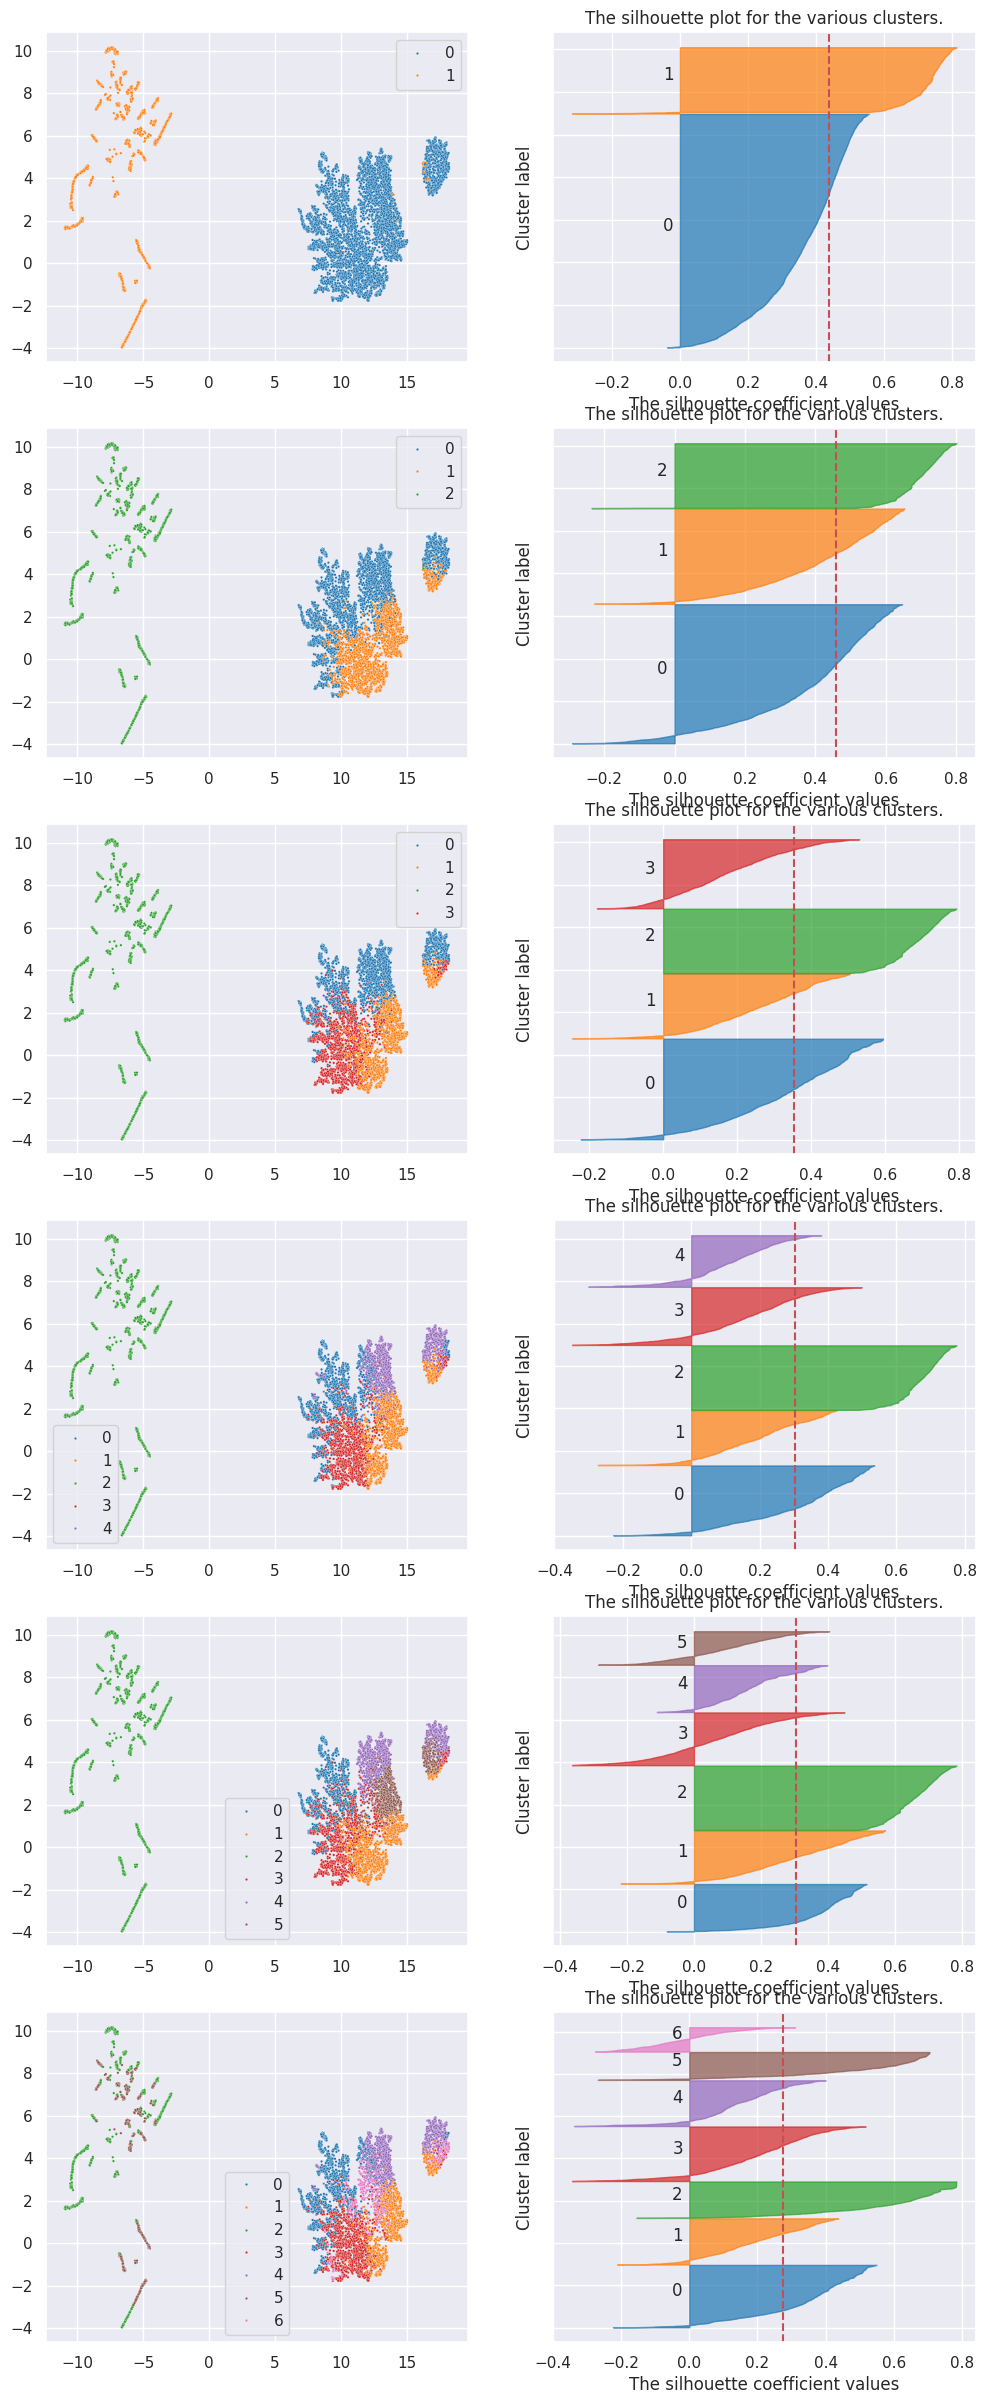

In [ ]:
# Perform clustering for multiple values of k
candidate_k = [2,3,4,5,6,7]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = []
silhouette_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2,
    figsize=(12, len(candidate_k)*5)
)

cluster_label_dict = {}

for i, num_clust in enumerate(candidate_k):

    print('Performing clustering for k = {}'.format(num_clust))

    # Perform clustering for current number of clusters
    kproto = KPrototypes(n_clusters=num_clust, init='Cao', n_jobs=8)

    kproto.fit(telco_df.to_numpy(), categorical=list(categ_idx))

    sns.scatterplot(
        x=umap_emb_data[:,0],
        y=umap_emb_data[:,1],
        hue=kproto.labels_,
        s=3, palette='tab10',
        ax=axs[i, 0]
    )

    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')

    curr_silhouette = plot_silouethes_score(
        data=kproto_pairwise,
        clusters=kproto.labels_,
        ax=axs[i, 1],
        distance_measure='precomputed',
        colormap=tab10
    )

    cluster_label_dict[num_clust] = kproto.labels_
    cost_list.append(kproto.cost_)
    silhouette_list.append(curr_silhouette)

plt.show()

# Silhouette Plots - Overall

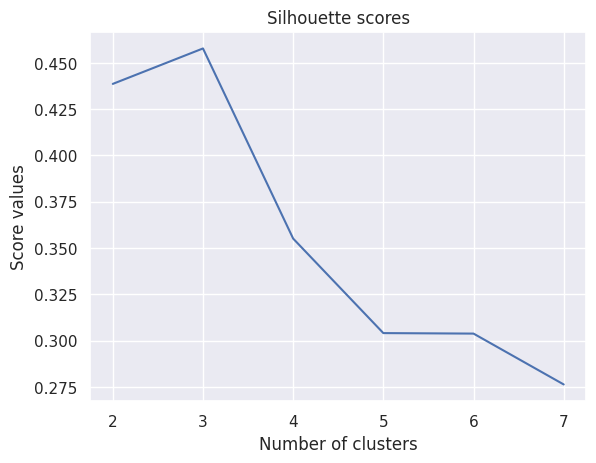

In [ ]:
plt.figure()
plt.plot(candidate_k, silhouette_list)
plt.title('Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Score values')
plt.show()

# Elbow Plot

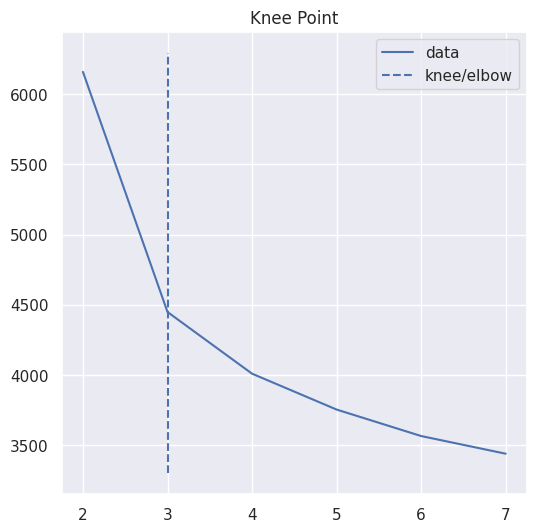

In [ ]:
# Use knee locator to find best number of clusters
kneedle = KneeLocator(
    candidate_k,
    cost_list,
    S=1.0,
    curve="convex",
    direction="decreasing"
)
kneedle.plot_knee()

In [ ]:
# uplot.points(umap_model, labels=original_df['Churn'].to_numpy())

In [ ]:
# uplot.points(umap_model, labels=cluster_label_dict[5])

In [ ]:
# Add cluster info to df
original_df['cluster'] = cluster_label_dict[5]

In [ ]:
original_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cluster
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,4
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,4
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,4
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


# Cluster & Feature Analysis

In [ ]:
original_df['cluster'].value_counts()

,count
cluster,
0,1645
2,1520
3,1360
1,1291
4,1216


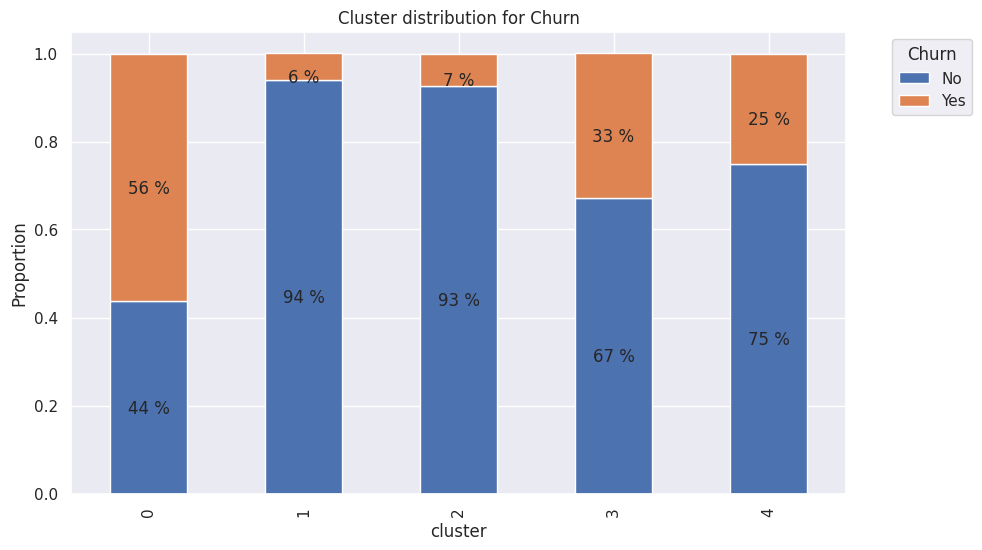

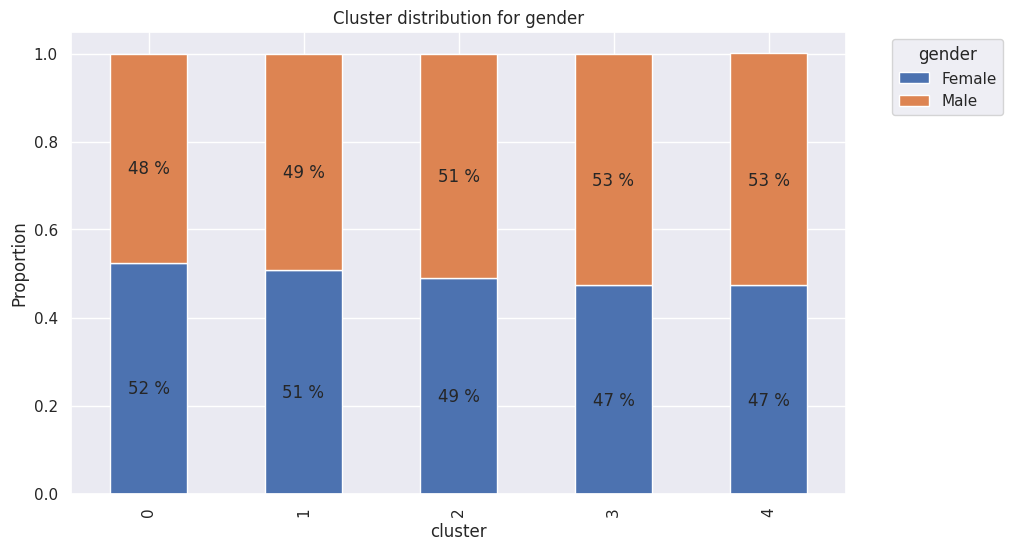

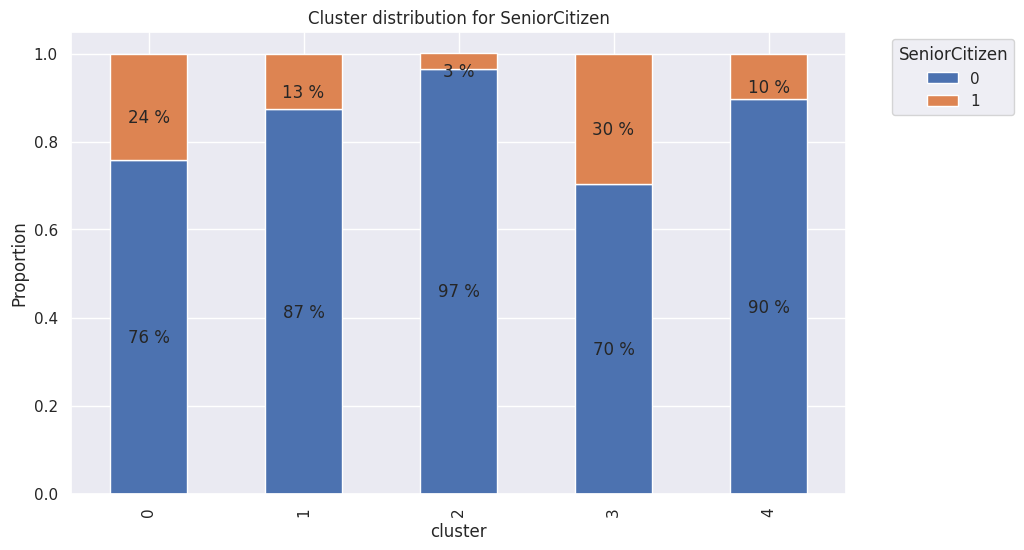

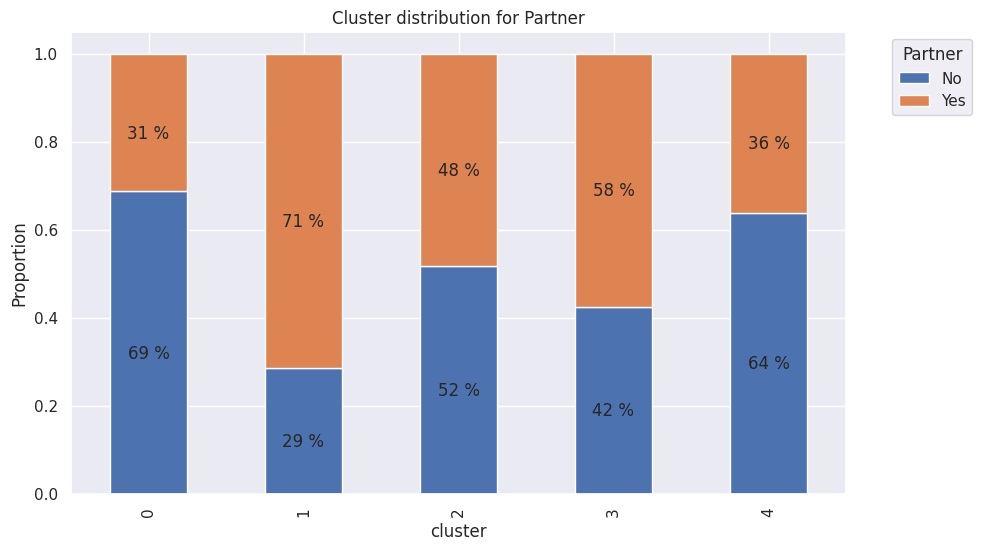

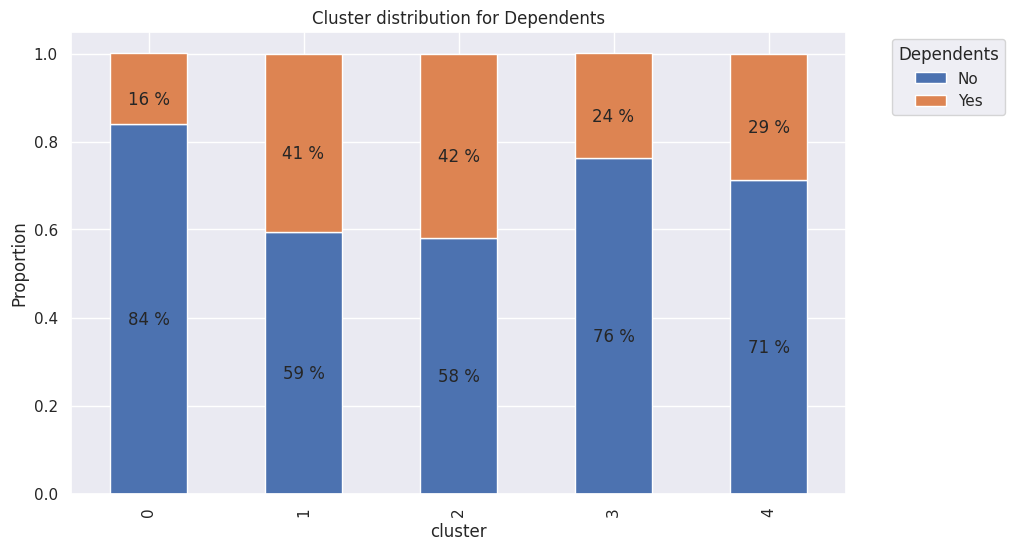

In [ ]:
# Plot other categorical data [not used during clustering]
for col in ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']:

    if col != 'cluster':

        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()

        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy()

                ax.text(x+width/2,
                        y+height/2,
                        '\n{:.0f} %'.format(height*100),
                        horizontalalignment='center',
                        verticalalignment='center')

        plt.show()

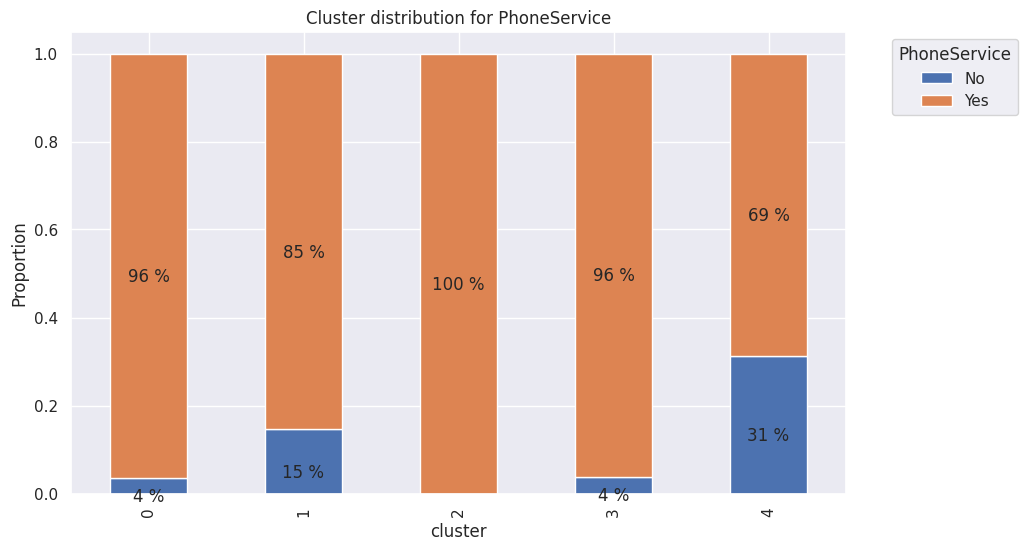

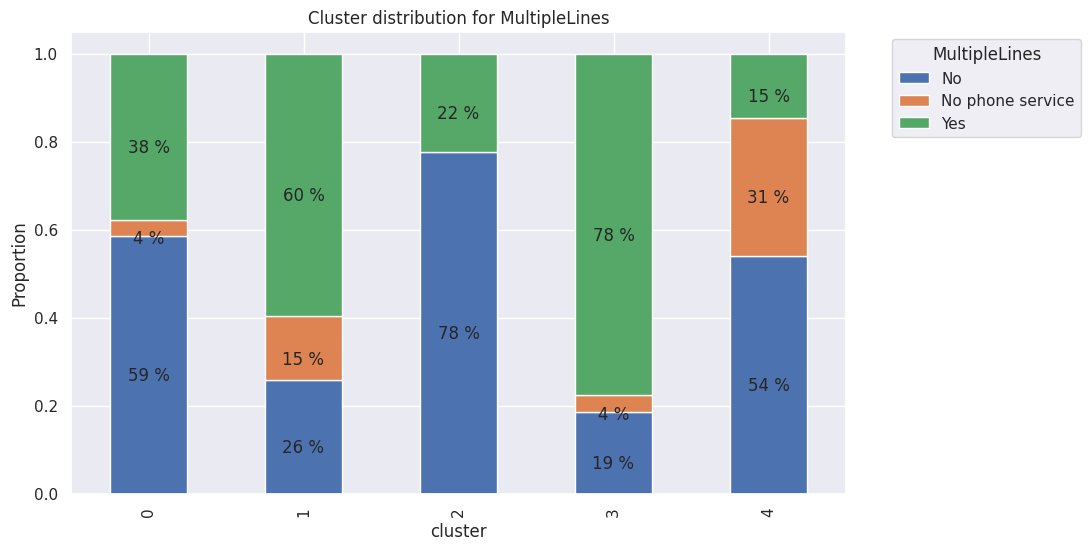

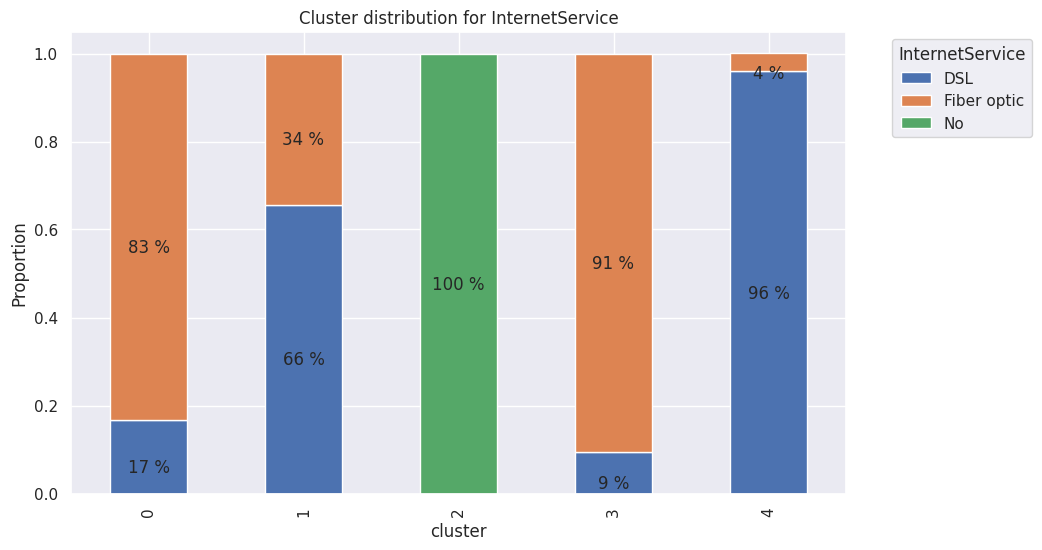

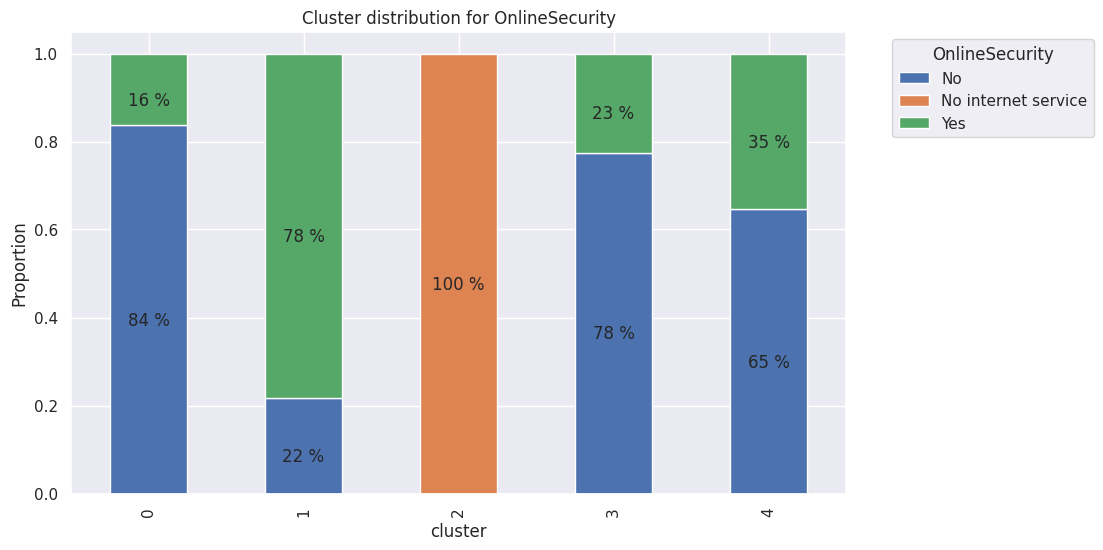

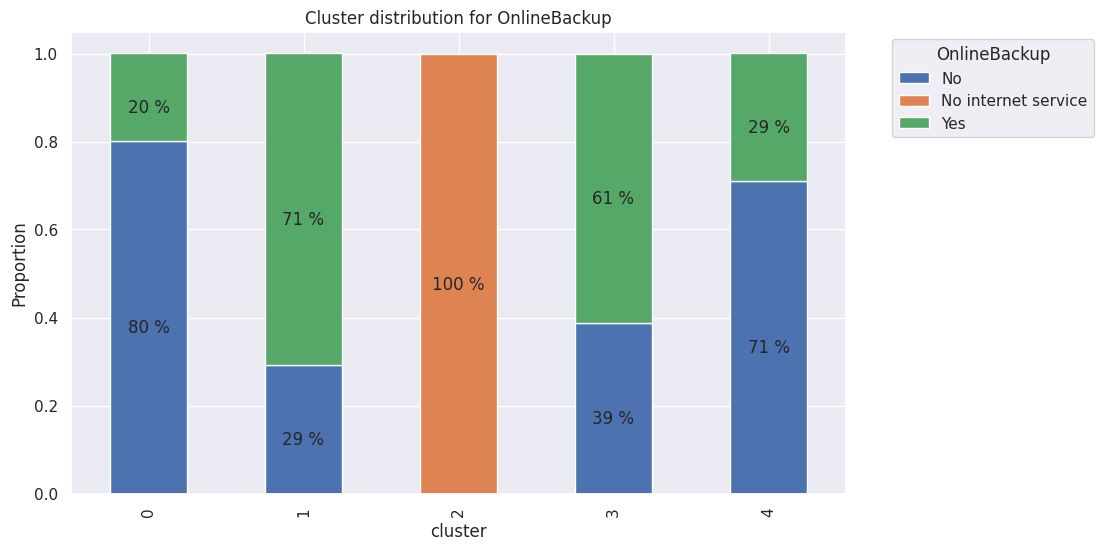

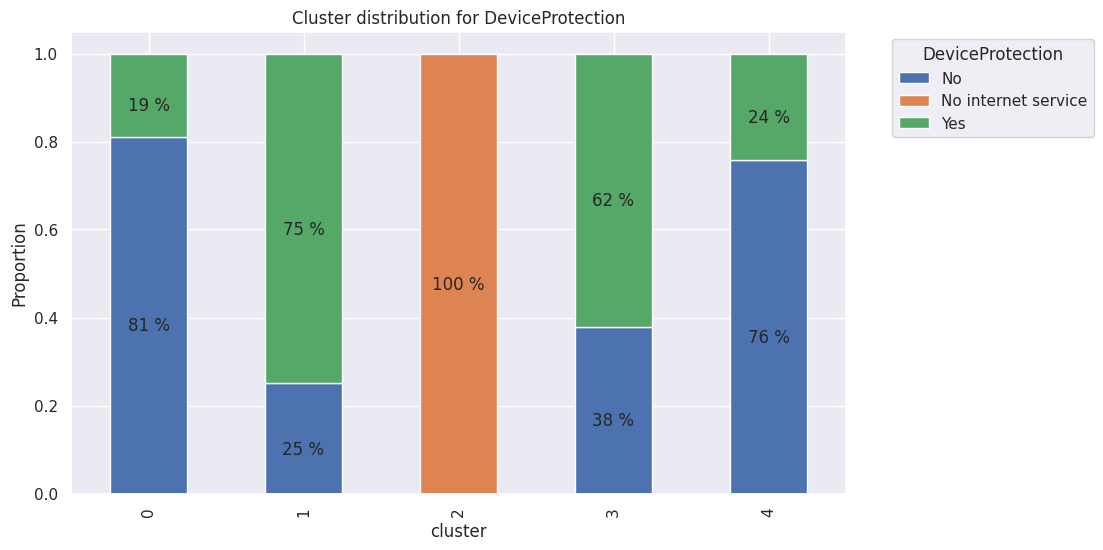

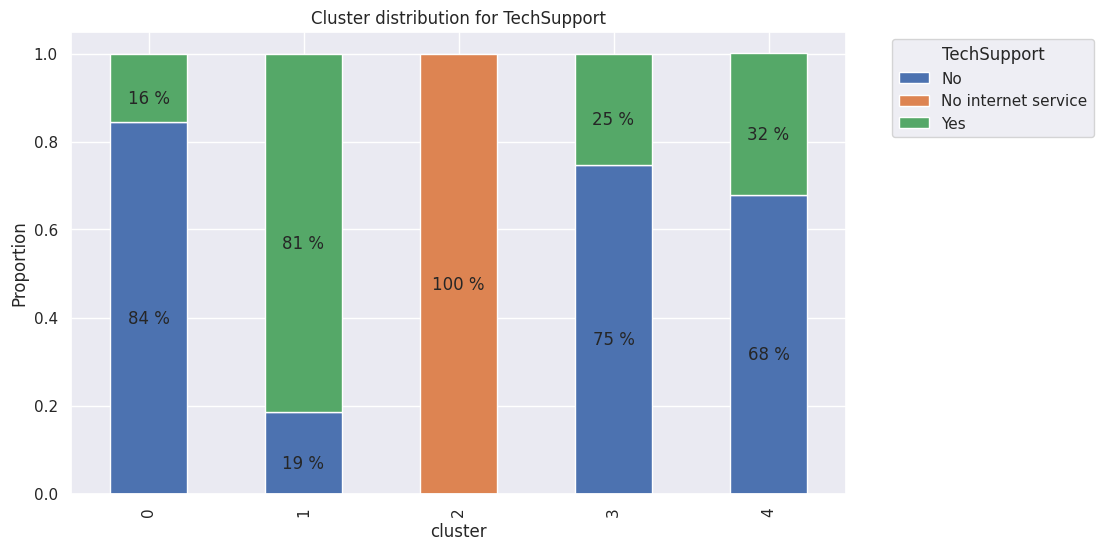

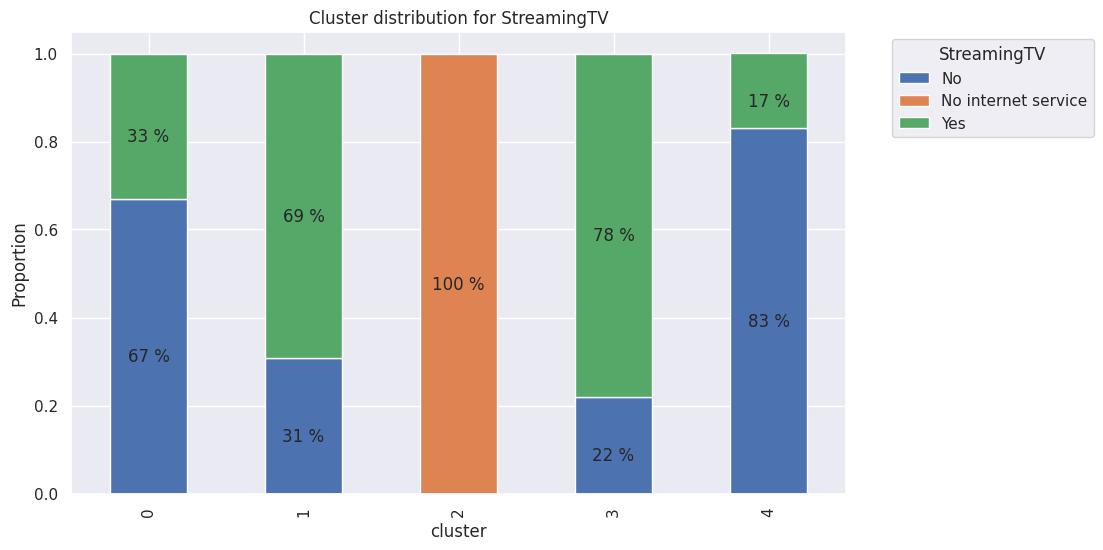

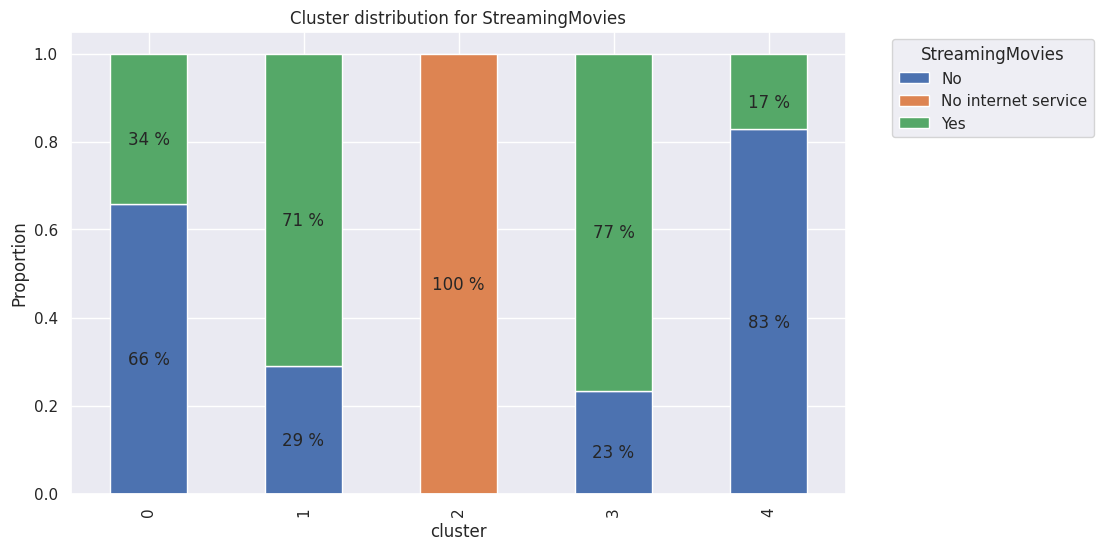

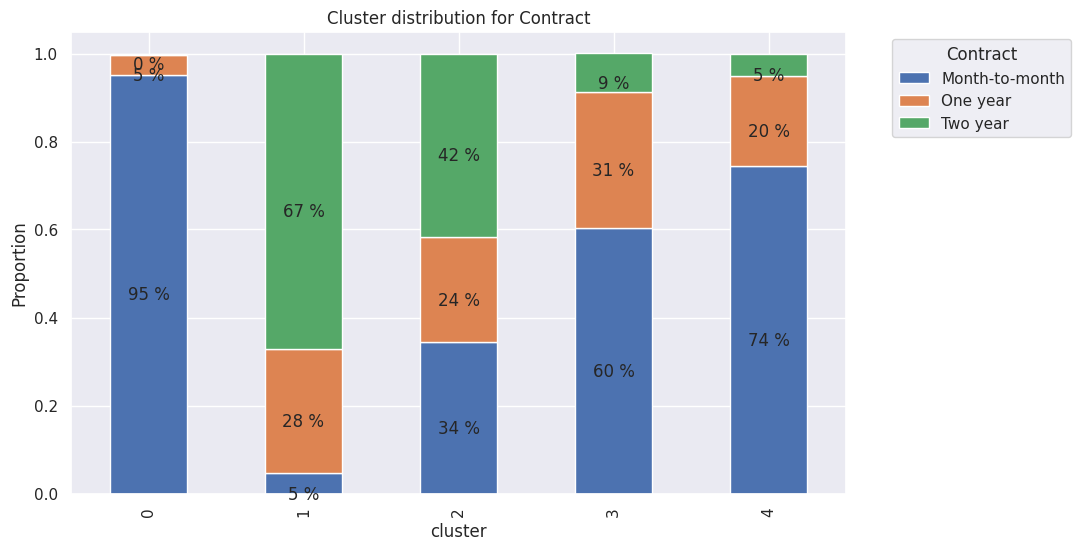

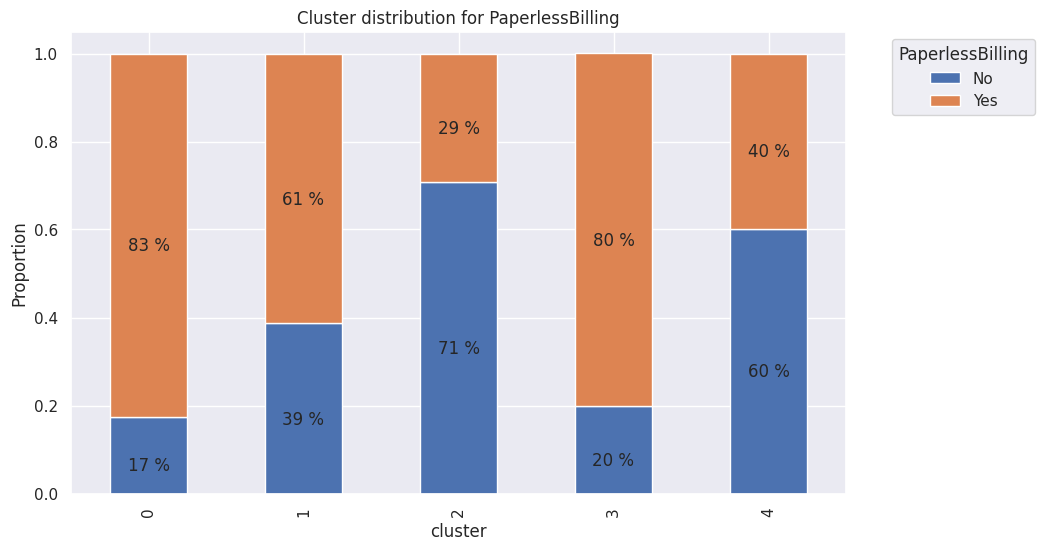

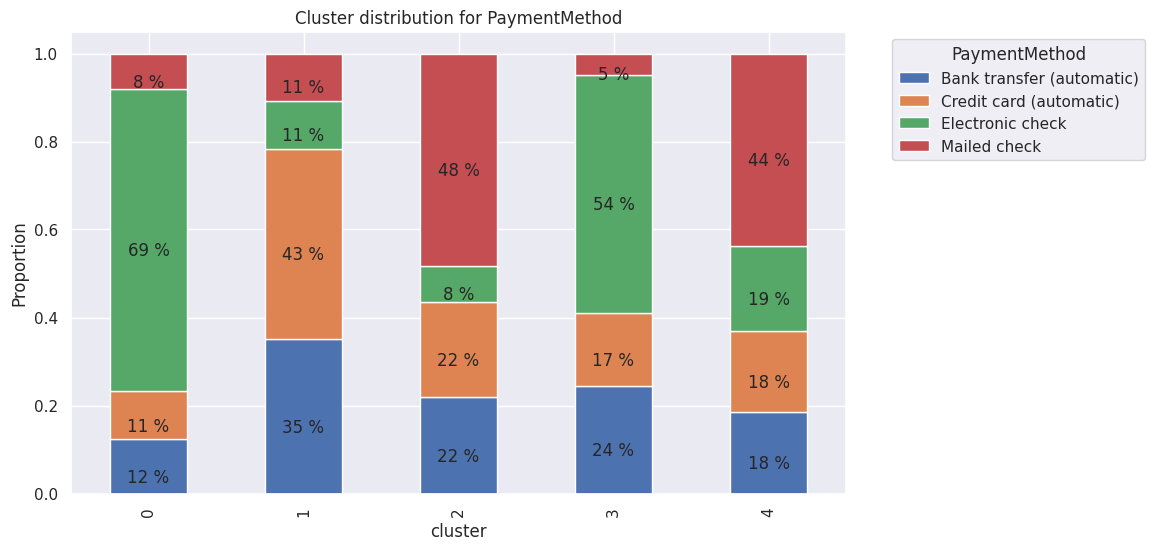

In [ ]:
# Categorical plots

for col in categ_cols:
    if col != 'cluster':

        # Calculate proportions
        proportions = original_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()

        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f'Cluster distribution for {col}')
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels on the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy()

                ax.text(x+width/2,
                        y+height/2,
                        '\n{:.0f} %'.format(height*100),
                        horizontalalignment='center',
                        verticalalignment='center')

        plt.show()

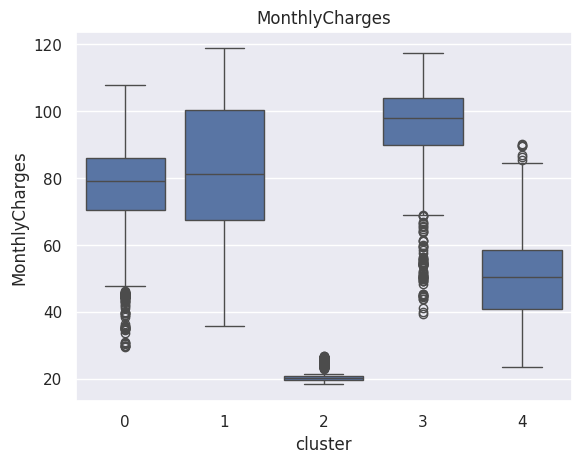

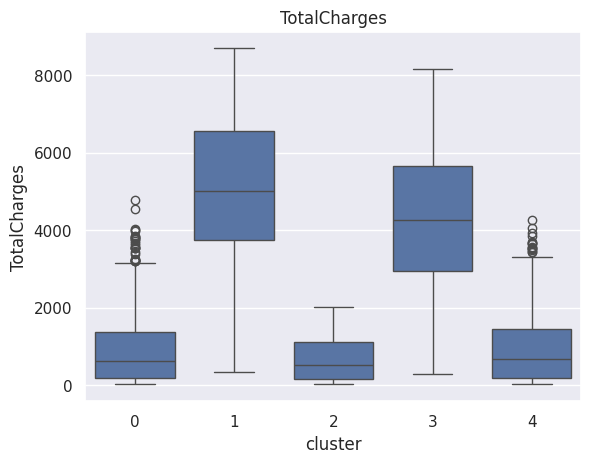

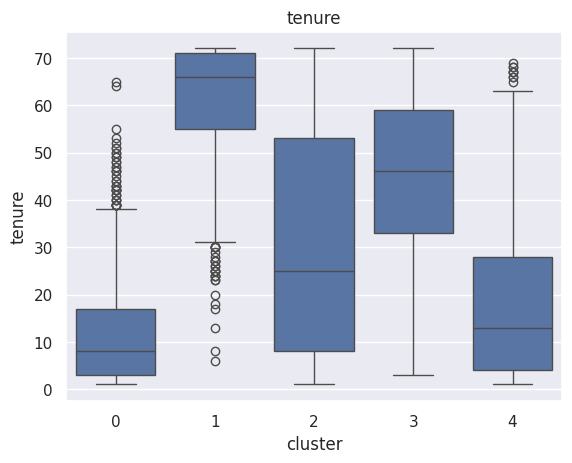

In [ ]:
# Plot numerical
for col in num_cols:

    plt.figure()
    sns.boxplot(original_df, x='cluster', y=col)
    plt.title(col)